<a href="https://colab.research.google.com/github/sramponi86/CAS_AIS_first_models/blob/main/W2_3_2_Sentiment_Analysis_LSTM_Adam_withPretrainedEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Sentiment Classification: LSTM

We continue the sentiment analysis on the IMDb dataset, and extent the bag-of-word approach of the previous notebook with the following components:
* we use an encoding that takes the order of the words into account
* we use pre-trained word embeddings
* we use LSTM layers to take into account the neightborhood of the words.

## Set-up
First of all, we need to load the libraries that we will need for this task. We will use keras and tensorflow for this code example, so we load the relevant parts of this framework:

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Flatten, LSTM, Bidirectional
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [3]:
# some more general libraries for evaluation purposes:
import matplotlib.pyplot as plt
import datetime
import pickle

In [4]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [5]:
# set some model parameters
VOCAB_SIZE = 5000
NUM_EPOCHS = 50 # set lower for fast results - set higher for good results
BUFFER_SIZE = 10000
BATCH_SIZE = 512
EMBED_DIM = 100

Optional: Set up Google Drive

In [6]:
use_gdrive = False
if use_gdrive:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount = True)

    # define target directories
    targetDir_root = 'gdrive/MyDrive/CAS_AIS_2024_FS/Results/'
    targetDir_models = targetDir_root + 'trainedWeights/'
    targetDir_results = targetDir_root + 'PerformanceMeasures/'

## Loading the Data
Also, the data loading as before:

In [7]:
train_ds, val_ds, test_ds = tfds.load(
    name = "imdb_reviews",
    split = [ 'train[:80%]', 'train[80%:]', 'test' ],
    as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCD8L25/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCD8L25/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCD8L25/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [8]:
for example, label in train_ds.take(1):
  print("Input: ", example)
  print(10*".")
  print('Target labels: ', label)
  print(50*"-")

Input:  tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
..........
Target labels:  tf.Tensor(0, shape=(), dtype=int64)
--------------------------------------------------


## Text Representation:
A first change considers the text representation: While we used `output_mode = "count"` in the previous notebook, we now drop this additional argument for the `TextVectorization`

In [9]:
encoderSEQ = TextVectorization(max_tokens=VOCAB_SIZE)
# previously, we had 'output_mode = "count", ' as additional arguments for TextVectorization
encoderSEQ.adapt(train_ds.map(lambda text, label: text))

The vocabulary is still the same as for the `encoderBoW`:

In [10]:
vocab = np.array(encoderSEQ.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U16')

The first word in the vocabulary is `[UNK]`, the token for the unknown words. Afterwards, we have a number of token for very common words, the so-called **stop words**. The first one being 'the'. So, in the numerical vector that we get after coding, the first column corresponds to all unknown words (i.e. all words that do not appear in the vocabulary), and the second column corresponds to the word 'the'. Also some *domain-specific* words occur frequenty: `movie` and `film` indicate that the vocabulary was built on movie reviews.

We can now get an example encoding:

In [11]:
encoderSEQ("the").numpy()

array([2])

In [12]:
example

<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">

In [13]:
encoderSEQ(example).numpy()

array([  11,   14,   34,  411,  376,   18,   90,   27,    1,    8,   33,
       1322, 4160,   41,  501,    1,  193,   25,   86,  152,   19,   11,
        216,  316,   27,   65,  241,  213,    8,  485,   56,   65,   86,
        115,   95,   22,    1,   11,   93,  635,  739,   11,   18,    7,
         34,  396,    1,  169, 2483,  409,    2,   88, 1205,  137,   67,
        144,   52,    2,    1,    1,   67,  245,   65, 2939,   16,    1,
       2795,    1,    1, 1441,    1,    3,   40,    1, 1659,   17, 4160,
         14,  156,   19,    4, 1205,  853,    1,    8,    4,   18,   12,
         14, 3839,    5,   98,  146, 1222,   10,  231,  683,   12,   48,
         25,   93,   39,   11,    1,  152,   39, 1322,    1,   50,  408,
         10,   95, 1157,  845,  140,    9])

Now, the output is a sequence of the word indices. So we can try to reconstruct the input text:

In [14]:
print("Original: ", example.numpy())
print("Reconstruction: ", " ".join(vocab[encoderSEQ(example)]))

Original:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Reconstruction:  this was an absolutely terrible movie dont be [UNK] in by christopher walken or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not [UNK] this movies ridiculous storyline this movie is an e

## Preparation for Model Comparison
We want to move on to more complex models. In order to be prepared, we first define a function that does the training and evaluation for us:

In [15]:
def fitAndEval(myModel, from_logits = True, model_name = ''):
    # compile
    myModel.compile(loss = BinaryCrossentropy(from_logits=from_logits),
                    optimizer = 'adam', metrics = ['accuracy'])

    # set seeds
    tf.random.set_seed(123)

    # Train
    myHistory = myModel.fit(
        train_ds.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE),
        validation_data = val_ds.batch(BATCH_SIZE),
        epochs = NUM_EPOCHS, verbose = 1,
        callbacks = [ EarlyStopping(monitor='val_accuracy', patience=5,
                                    verbose=False, restore_best_weights=True)])

    # Evaluate Training Progress
    myHistory_dict = myHistory.history
    myHistory_dict.keys()

    resDict = {}
    resDict['train_loss'] = myHistory_dict['loss']
    resDict['val_loss'] = myHistory_dict['val_loss']
    resDict['train_accuracy'] = myHistory_dict['accuracy']
    resDict['val_accuracy'] = myHistory_dict['val_accuracy']
    resDict['epochs'] = range(1, len(resDict['train_accuracy']) + 1)
    resDict['model_name'] = model_name

    return resDict

# A first LSTM Model
Now, let's define and train our first LSTM using the helper function `fitAndEval`:

In [16]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [17]:
model_embed_1LSTM = Sequential()
model_embed_1LSTM.add(Input(shape=(1,), dtype='string'))
model_embed_1LSTM.add(encoderSEQ)
model_embed_1LSTM.add(Embedding(VOCAB_SIZE, EMBED_DIM))
model_embed_1LSTM.add(Bidirectional(LSTM(64)))
model_embed_1LSTM.add(Dense(1, activation="sigmoid"))

This is the first model that will need a significant training time. Therefore, we have implemented two variants of running this notebook - either to train the models from scratch, or to use the precomputed weights. To run the model from scratch, set `train_from_scatch` to `True`. We suggest you don't change the model and file names, so it will save the parameters of the results when you train from scratch, and it will load the model weights and results otherwise.

In [19]:
train_from_scatch = True

model_name = 'model_5kW_embed_1LSTM_ADAM'
model_weight_file = model_name + '_weights'
model_result_file = model_name + '_Results.pkl'

if train_from_scatch:
    resDict_embed_1LSTM = fitAndEval(model_embed_1LSTM, from_logits=False,
                                     model_name = model_name)
    # save weights and results
    model_embed_1LSTM.save_weights(model_weight_file)
    with open(model_result_file, 'wb') as f:
        pickle.dump(resDict_embed_1LSTM, f)
else:
    model_embed_1LSTM.load_weights(model_weight_file)
    with open(model_result_file, 'rb') as input_file:
        resDict_embed_1LSTM = pickle.load(input_file)

Epoch 1/50
40/40 [==============================] - 23s 405ms/step - loss: 0.6832 - accuracy: 0.5767 - val_loss: 0.6564 - val_accuracy: 0.6722
Epoch 2/50
40/40 [==============================] - 13s 313ms/step - loss: 0.5623 - accuracy: 0.7422 - val_loss: 0.4504 - val_accuracy: 0.8128
Epoch 3/50
40/40 [==============================] - 13s 314ms/step - loss: 0.3832 - accuracy: 0.8429 - val_loss: 0.3650 - val_accuracy: 0.8510
Epoch 4/50
40/40 [==============================] - 11s 277ms/step - loss: 0.2905 - accuracy: 0.8889 - val_loss: 0.3662 - val_accuracy: 0.8698
Epoch 5/50
40/40 [==============================] - 12s 282ms/step - loss: 0.2478 - accuracy: 0.9103 - val_loss: 0.3942 - val_accuracy: 0.8464
Epoch 6/50
40/40 [==============================] - 12s 296ms/step - loss: 0.2325 - accuracy: 0.9162 - val_loss: 0.3466 - val_accuracy: 0.8738
Epoch 7/50
40/40 [==============================] - 11s 270ms/step - loss: 0.1910 - accuracy: 0.9340 - val_loss: 0.3574 - val_accuracy: 0.8744

In [20]:
resDict_embed_1LSTM['model_name'] = model_name

resDict_embed_1LSTM['model_name']

model_name = 'model_5kW_embed_1LSTM_ADAM'
model_weight_file = model_name + '_weights'
model_result_file = model_name + '_Results.pkl'
model_result_file

'model_5kW_embed_1LSTM_ADAM_Results.pkl'

In [21]:
with open(model_result_file, 'wb') as f:
    pickle.dump(resDict_embed_1LSTM, f)


In [22]:
model_embed_1LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 100)         500000    
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 584609 (2.23 MB)
Trainable params: 584609 (2.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


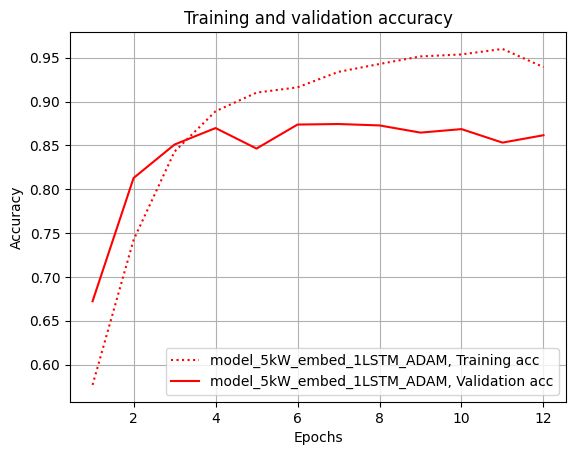

In [23]:
plt.plot(resDict_embed_1LSTM['epochs'], resDict_embed_1LSTM['train_accuracy'],
         'r:', label = resDict_embed_1LSTM['model_name'] +', Training acc')
plt.plot(resDict_embed_1LSTM['epochs'], resDict_embed_1LSTM['val_accuracy'],
         'r',  label = resDict_embed_1LSTM['model_name'] +', Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

We see that our model does quite some overfitting: On the training set, it reaches an accuracy of over 95% in several epochs, but on the validation data, the performance does not go above approx. 86%.

# Using Pretrained Word Embeddings


Here, we are using the pretrained word embeddings from glove:

In [24]:
have_glove = True # set to true when downloaded

if use_gdrive & have_glove:
    glove_file = targetDir_models + 'glove.6B.100d.txt'
    # have_glove = !test -f $glove_file;
    %cp gdrive/MyDrive/CAS_AIS_2024_FS/Results/trainedWeights/glove.6B.100d.txt .

else:
    # The following commands need to be executed the first time this notebook is ran:
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

if use_gdrive:
    %cp glove.6B.100d.txt !targetDir_models

--2024-03-01 13:28:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-01 13:28:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-01 13:28:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Now we will use these pretrained word vectors to represent our texts:

In [25]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [26]:
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
for i, word in enumerate(encoderSEQ.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        # print(word)
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4918 words (82 misses)


## Pretrained Word Embeddings without Adaptation
We use the same LSTM model as above, but initialize the embedding with the pretrained data from gloVe.

In [27]:
model_pe100_1LSTM = Sequential()
model_pe100_1LSTM.add(Input(shape=(1,), dtype='string'))
model_pe100_1LSTM.add(encoderSEQ)
model_pe100_1LSTM.add(Embedding(
    VOCAB_SIZE,
    EMBED_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False))
model_pe100_1LSTM.add(Bidirectional(LSTM(64)))
model_pe100_1LSTM.add(Dense(1, activation="sigmoid"))

In [28]:
train_from_scatch = True

model_name = 'model_5kW_pe100_1LSTM_ADAM'
model_weight_file = model_name + '_weights'
model_result_file = model_name + '_Results.pkl'

if train_from_scatch:
    resDict_pe100_1LSTM = fitAndEval(model_pe100_1LSTM, from_logits=False,
                                     model_name = model_name)
    # save weights and results
    model_pe100_1LSTM.save_weights(model_weight_file)
    with open(model_result_file, 'wb') as f:
        pickle.dump(resDict_pe100_1LSTM, f)
else:
    model_pe100_1LSTM.load_weights(model_weight_file)
    with open(model_result_file, 'rb') as input_file:
        resDict_pe100_1LSTM = pickle.load(input_file)

Epoch 1/50
40/40 [==============================] - 15s 237ms/step - loss: 0.6618 - accuracy: 0.6015 - val_loss: 0.6165 - val_accuracy: 0.6866
Epoch 2/50
40/40 [==============================] - 10s 240ms/step - loss: 0.6240 - accuracy: 0.6608 - val_loss: 0.6114 - val_accuracy: 0.6820
Epoch 3/50
40/40 [==============================] - 9s 226ms/step - loss: 0.5691 - accuracy: 0.7213 - val_loss: 0.5249 - val_accuracy: 0.7524
Epoch 4/50
40/40 [==============================] - 9s 227ms/step - loss: 0.5161 - accuracy: 0.7582 - val_loss: 0.4931 - val_accuracy: 0.7784
Epoch 5/50
40/40 [==============================] - 10s 234ms/step - loss: 0.5141 - accuracy: 0.7581 - val_loss: 0.5909 - val_accuracy: 0.7218
Epoch 6/50
40/40 [==============================] - 9s 222ms/step - loss: 0.7044 - accuracy: 0.5637 - val_loss: 0.6873 - val_accuracy: 0.5328
Epoch 7/50
40/40 [==============================] - 10s 245ms/step - loss: 0.6815 - accuracy: 0.5806 - val_loss: 0.6798 - val_accuracy: 0.5924
Ep

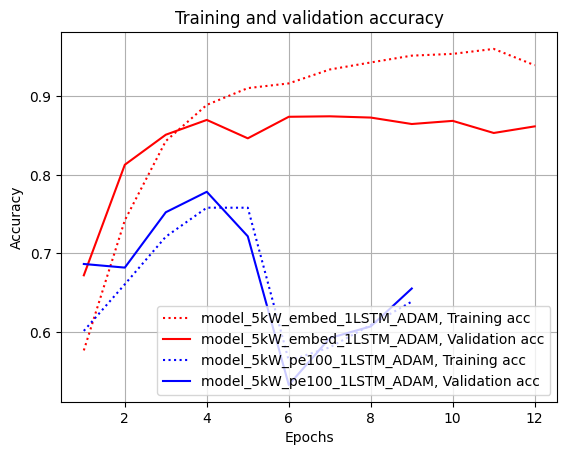

In [29]:
plt.plot(resDict_embed_1LSTM['epochs'], resDict_embed_1LSTM['train_accuracy'],
         'r:', label = resDict_embed_1LSTM['model_name'] +', Training acc')
plt.plot(resDict_embed_1LSTM['epochs'], resDict_embed_1LSTM['val_accuracy'],
         'r',  label = resDict_embed_1LSTM['model_name'] +', Validation acc')

plt.plot(resDict_pe100_1LSTM['epochs'], resDict_pe100_1LSTM['train_accuracy'],
         'b:', label = resDict_pe100_1LSTM['model_name'] +', Training acc')
plt.plot(resDict_pe100_1LSTM['epochs'], resDict_pe100_1LSTM['val_accuracy'],
         'b',  label = resDict_pe100_1LSTM['model_name'] +', Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Pretrained Word Embeddings with Adaptation
As we have seen the performance actually falling below the performance of the LSTM model with embeddings trained from scratch, we implement a third model, where the pretrained embeddings serve as starting point, from where we allow the model to further train and adapt the embeddings as needed.

In [30]:
model_ae100_1LSTM = Sequential()
model_ae100_1LSTM.add(Input(shape=(1,), dtype='string'))
model_ae100_1LSTM.add(encoderSEQ)
model_ae100_1LSTM.add(Embedding(
    VOCAB_SIZE,
    EMBED_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=True))
model_ae100_1LSTM.add(Bidirectional(LSTM(64)))
model_ae100_1LSTM.add(Dense(1, activation="sigmoid"))

In [31]:
train_from_scatch = True

model_name = 'model_5kW_ae100_1LSTM_ADAM'
model_weight_file = model_name + '_weights'
model_result_file = model_name + '_Results.pkl'

if train_from_scatch:
    resDict_ae100_1LSTM = fitAndEval(model_ae100_1LSTM, from_logits=False,
                                     model_name = model_name)
    # save weights and results
    model_ae100_1LSTM.save_weights(model_weight_file)
    with open(model_result_file, 'wb') as f:
        pickle.dump(resDict_ae100_1LSTM, f)
else:
    model_ae100_1LSTM.load_weights(model_weight_file)
    with open(model_result_file, 'rb') as input_file:
        resDict_ae100_1LSTM = pickle.load(input_file)

Epoch 1/50
40/40 [==============================] - 20s 379ms/step - loss: 0.6602 - accuracy: 0.5959 - val_loss: 0.5738 - val_accuracy: 0.7118
Epoch 2/50
40/40 [==============================] - 12s 284ms/step - loss: 0.5720 - accuracy: 0.7122 - val_loss: 0.5926 - val_accuracy: 0.7264
Epoch 3/50
40/40 [==============================] - 11s 266ms/step - loss: 0.5144 - accuracy: 0.7591 - val_loss: 0.4501 - val_accuracy: 0.8054
Epoch 4/50
40/40 [==============================] - 11s 256ms/step - loss: 0.4483 - accuracy: 0.8076 - val_loss: 0.4746 - val_accuracy: 0.7902
Epoch 5/50
40/40 [==============================] - 12s 293ms/step - loss: 0.3933 - accuracy: 0.8399 - val_loss: 0.4160 - val_accuracy: 0.8236
Epoch 6/50
40/40 [==============================] - 12s 285ms/step - loss: 0.3775 - accuracy: 0.8454 - val_loss: 0.3800 - val_accuracy: 0.8360
Epoch 7/50
40/40 [==============================] - 11s 263ms/step - loss: 0.3388 - accuracy: 0.8652 - val_loss: 0.3896 - val_accuracy: 0.8318

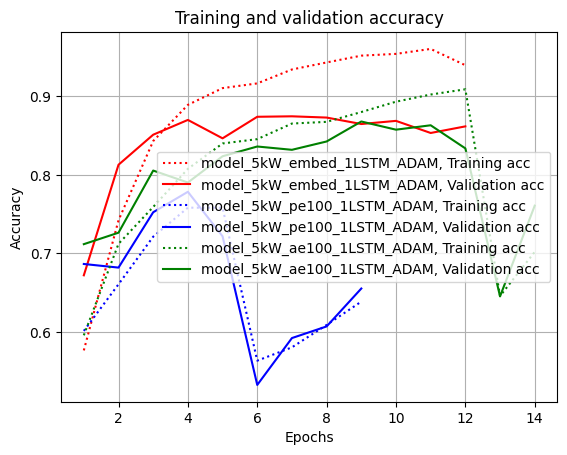

In [32]:
plt.plot(resDict_embed_1LSTM['epochs'], resDict_embed_1LSTM['train_accuracy'],
         'r:', label = resDict_embed_1LSTM['model_name'] +', Training acc')
plt.plot(resDict_embed_1LSTM['epochs'], resDict_embed_1LSTM['val_accuracy'],
         'r',  label = resDict_embed_1LSTM['model_name'] +', Validation acc')

plt.plot(resDict_pe100_1LSTM['epochs'], resDict_pe100_1LSTM['train_accuracy'],
         'b:', label = resDict_pe100_1LSTM['model_name'] +', Training acc')
plt.plot(resDict_pe100_1LSTM['epochs'], resDict_pe100_1LSTM['val_accuracy'],
         'b',  label = resDict_pe100_1LSTM['model_name'] +', Validation acc')

plt.plot(resDict_ae100_1LSTM['epochs'], resDict_ae100_1LSTM['train_accuracy'],
         'g:', label = resDict_ae100_1LSTM['model_name'] +', Training acc')
plt.plot(resDict_ae100_1LSTM['epochs'], resDict_ae100_1LSTM['val_accuracy'],
         'g',  label = resDict_ae100_1LSTM['model_name'] +', Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Copy files to Google Drive (if wanted):

In [33]:
# copy files
if use_gdrive:
    %cp model_pe100_1LSTM_weights* $targetDir_models
    %cp model_pe100_1LSTM_Results* $targetDir_results
    %cp model_embed_1LSTM_weights* $targetDir_models
    %cp model_embed_1LSTM_Results* $targetDir_results
    %cp model_ae100_1LSTM_weights* $targetDir_models
    %cp model_ae100_1LSTM_Results* $targetDir_results